In [27]:
import pandas as pd
import plotly.graph_objs as go 
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from tqdm import tqdm 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Import des données

In [1]:
apple = pd.read_csv("../data/AAPL.csv")
amazon = pd.read_csv("../data/AMZN.csv")
berkshire = pd.read_csv("../data/BRK-B.csv")
google = pd.read_csv("../data/GOOG.csv")
meta = pd.read_csv("../data/META.csv")
microsoft = pd.read_csv("../data/MSFT.csv")
nvidia = pd.read_csv("../data/NVDA.csv")
tesla = pd.read_csv("../data/TSLA.csv")
unitedhealth = pd.read_csv("../data/UNH.csv")
exxon = pd.read_csv("../data/XOM.csv")

NameError: name 'pd' is not defined

In [3]:
titres = {"Apple" : apple, 
          "Amazon" : amazon,
          "Berkshire" : berkshire,
          "Google" : google,
          "Meta" : meta,
          "Microsoft" : microsoft,
          "Nvidia" : nvidia,
          "Tesla" : tesla,
          "UnitedHealth" : unitedhealth,
          "Exxon" : exxon}

# Calcul des prédictions

In [52]:
def stock_forecast(stock):
    stock['Date'] = pd.to_datetime(stock['Date'])
    #stock['Volatility_HighLow_10days'] = stock['High'].rolling(window=10).std() / stock['Low'].rolling(window=10).mean()
    stock['Return'] = stock['Close'].pct_change()
    stock = stock.dropna()
    stock = stock.drop(columns=["Open", 'Adj Close'])
    
    stock['Target'] = stock['Return'].shift(-7)
    stock = stock.dropna()
    
    stock['Return_Lag1'] = stock['Return'].shift(3)

# Supprimer les lignes avec des valeurs NaN résultant des lags
    stock = stock.dropna()

    window_size = 90  
    step_size = 7  
    prediction_days = 7
    
    prediction_dates = []
    predictions = []
    for start in tqdm(range(0, len(stock) - window_size - prediction_days, step_size)):
        end = start + window_size
        train = stock.iloc[start:end]
        test = stock.iloc[end:end + prediction_days]
    
        model = XGBRegressor(max_depth = 15, n_estimators = 500)
        model.fit(train.drop(['Date', 'Target', 'Volume'], axis=1), train['Target'])
    
        pred = model.predict(test.drop(['Date', 'Target', 'Volume'], axis=1))
        predictions.append(pred)
    
        prediction_date = stock.iloc[end + prediction_days - 1]['Date']
        prediction_dates.append(prediction_date)

    predictions = [value[0] for value in predictions]


    df_predictions = pd.DataFrame({
        'Date': prediction_dates,
        'Prediction': predictions
    })
    
    merged_df = stock.merge(df_predictions, on='Date', how='inner')
    
    merged_df = merged_df.drop(columns = ["Target"])
    
    return(merged_df)

In [53]:
predictions_dic = {}

In [54]:
for key in titres :
    predictions_dic[key] = stock_forecast(titres[key])

100%|██████████| 379/379 [00:34<00:00, 10.84it/s]


# Performance des prédictions individuelles

In [57]:
def display_return(ptf, name, ax):
    # Tracer les prédictions et les retours réels
    ax.plot(ptf.Date, ptf['Prediction'], label='Prediction', fillstyle='bottom')
    ax.plot(ptf.Date, ptf['Return'], label='Return', fillstyle='bottom')
    
    # Mise à jour des titres et des légendes
    ax.set_title(f"Évolution des returns de {name}")
    ax.set_xlabel('Date')
    ax.set_ylabel('Valeur')
    ax.legend()

def display_evolution(ptf, name, ax):
    # Calculs pour les valeurs de portefeuille
    ptf['Real_Portfolio_Value'] = 1000 * (1 + ptf['Return']).cumprod()
    ptf['Predicted_Portfolio_Value'] = 1000 * (1 + ptf['Prediction']).cumprod()

    # Tracer les valeurs réelles et prédites du portefeuille
    ax.plot(ptf.Date, ptf['Real_Portfolio_Value'], label='Valeur Réelle', fillstyle='bottom')
    ax.plot(ptf.Date, ptf['Predicted_Portfolio_Value'], label='Valeur Prédite', fillstyle='bottom')

    # Mise à jour des titres et des légendes
    ax.set_title(f"Évolution de la valeur de {name}")
    ax.set_xlabel('Date')
    ax.set_ylabel('Valeur')
    ax.legend()

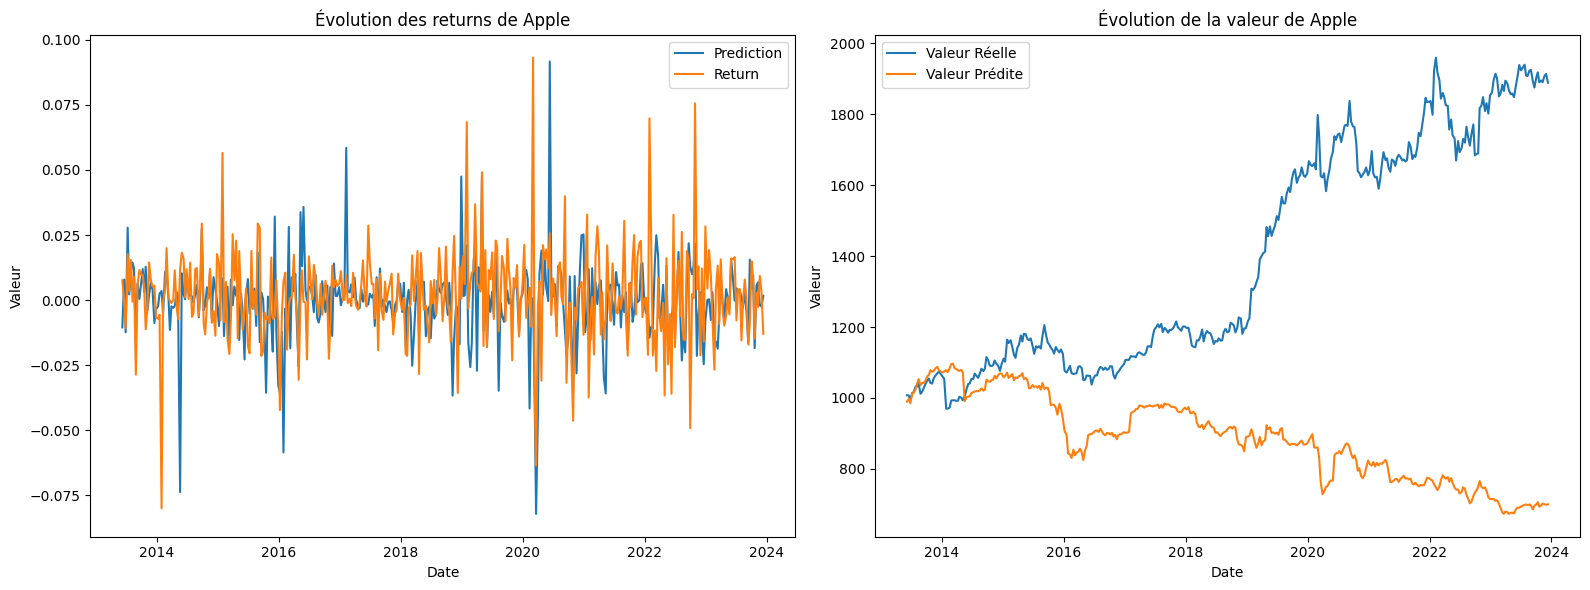

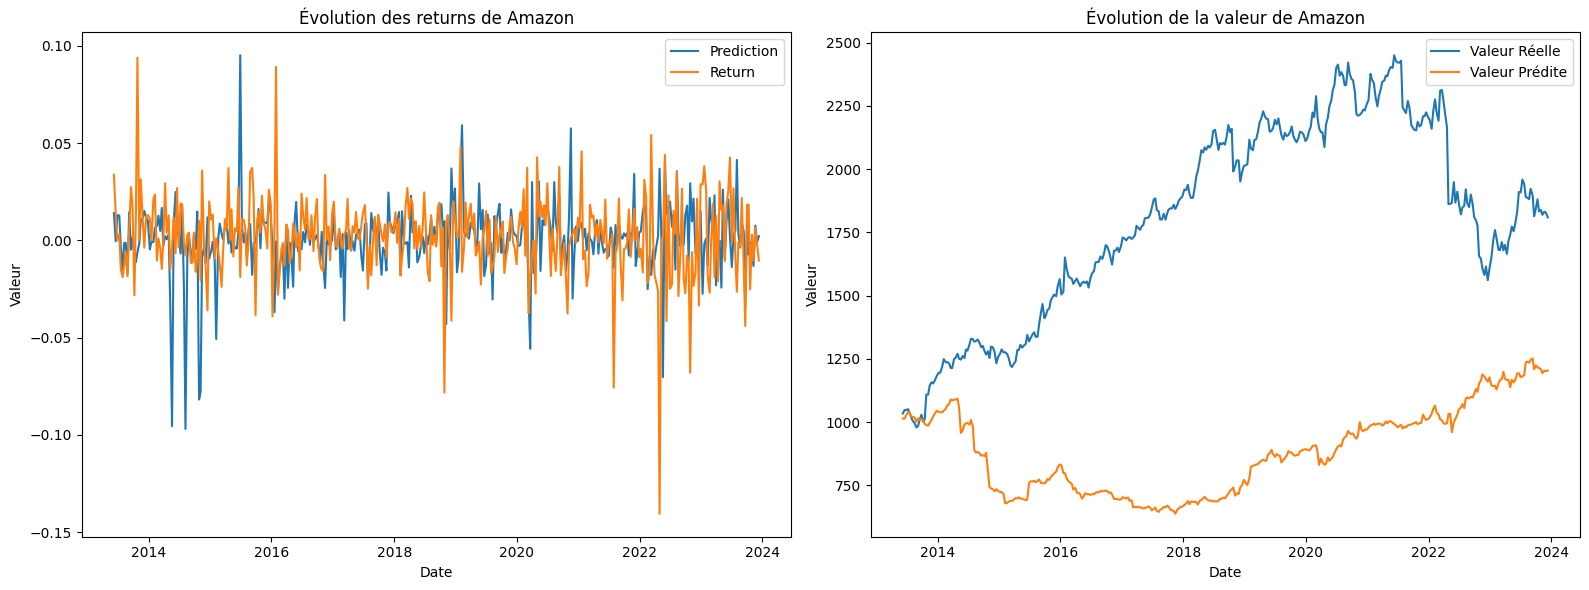

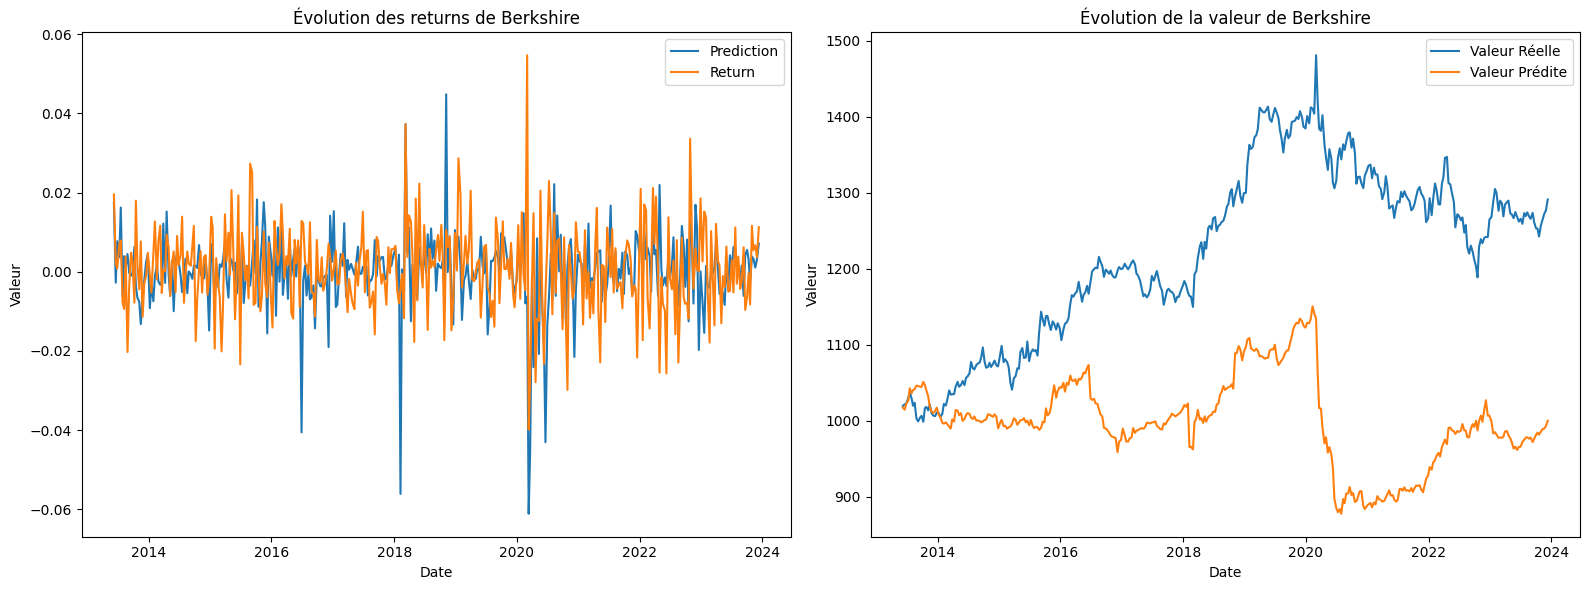

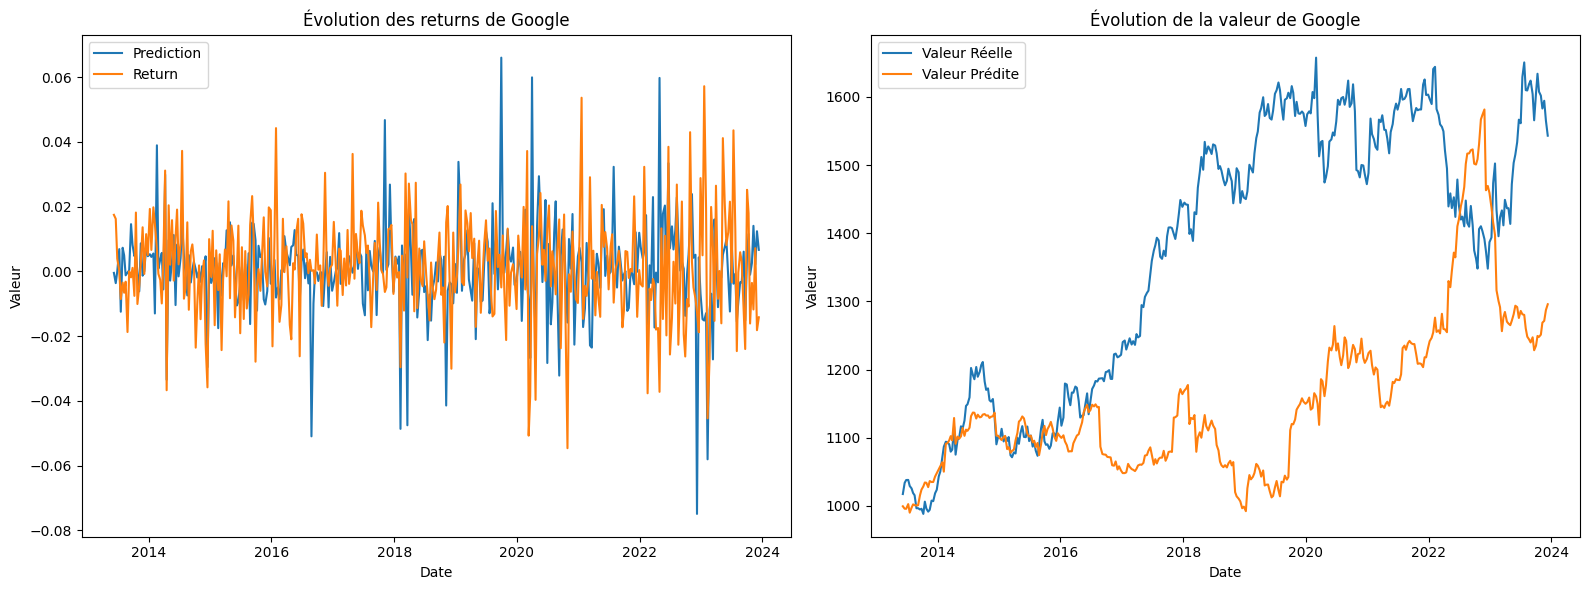

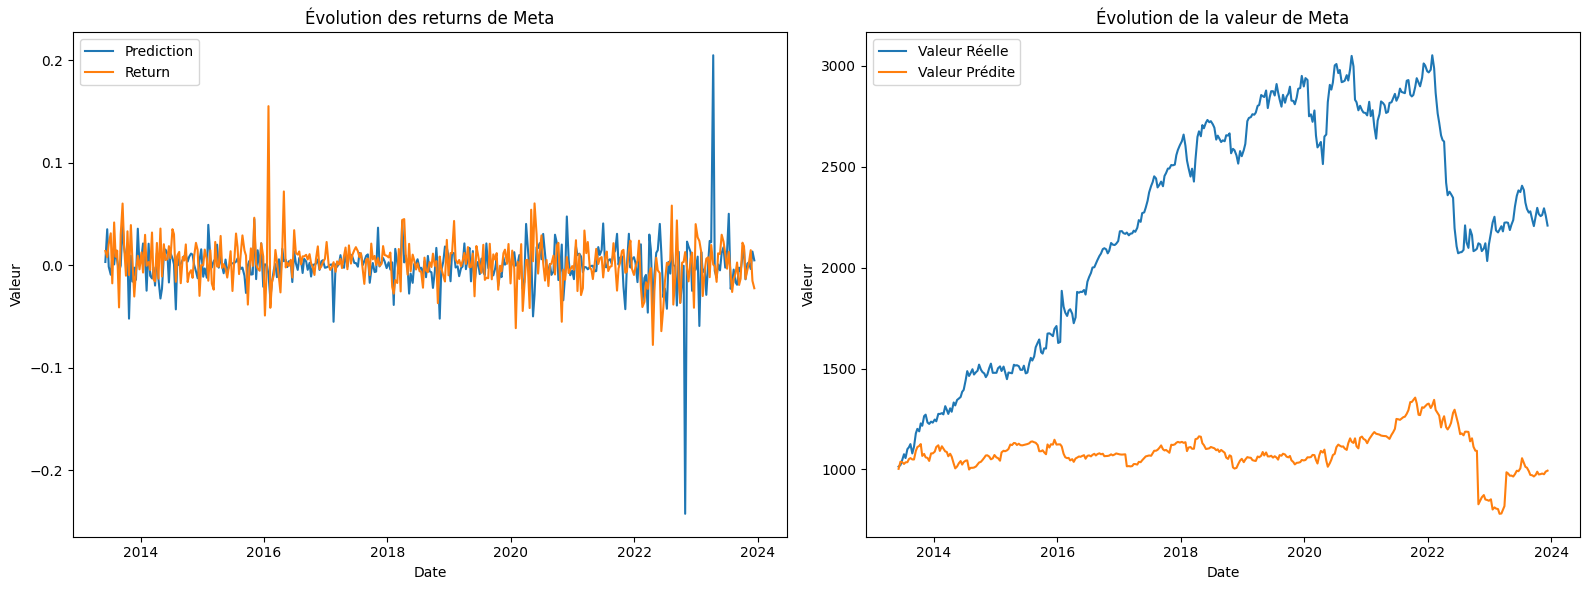

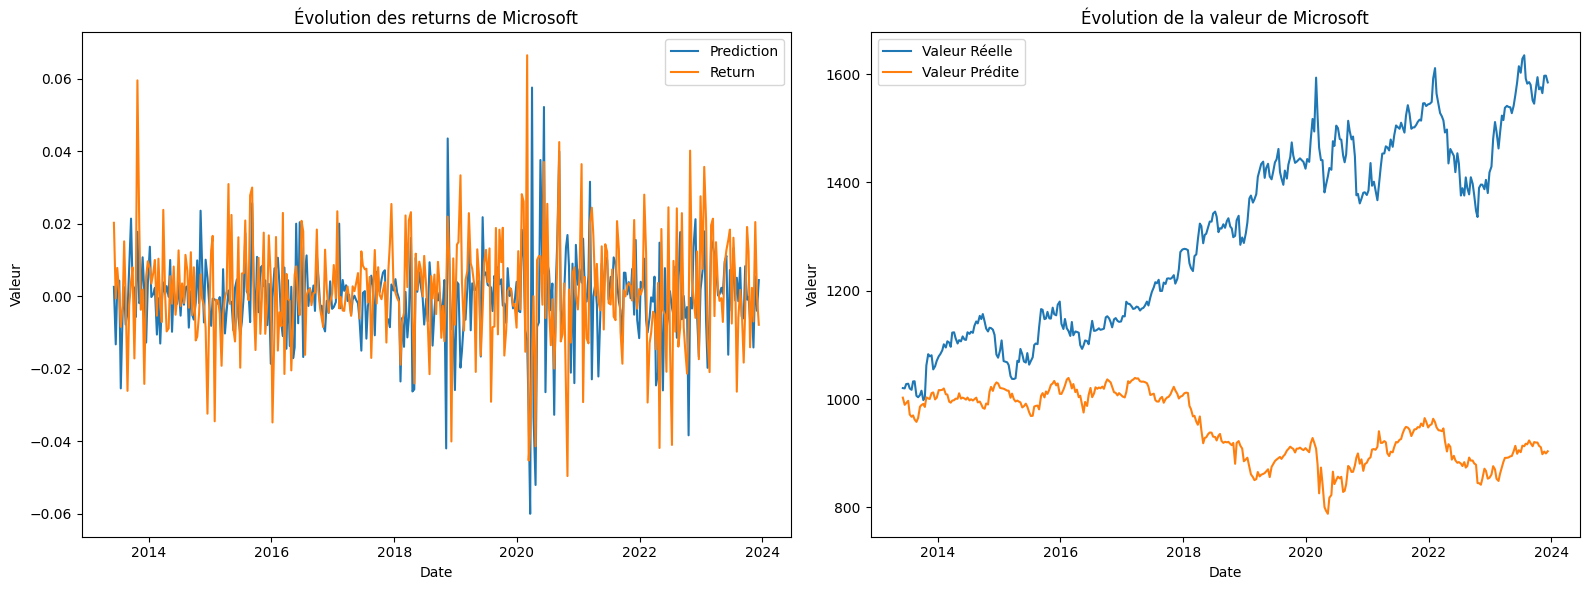

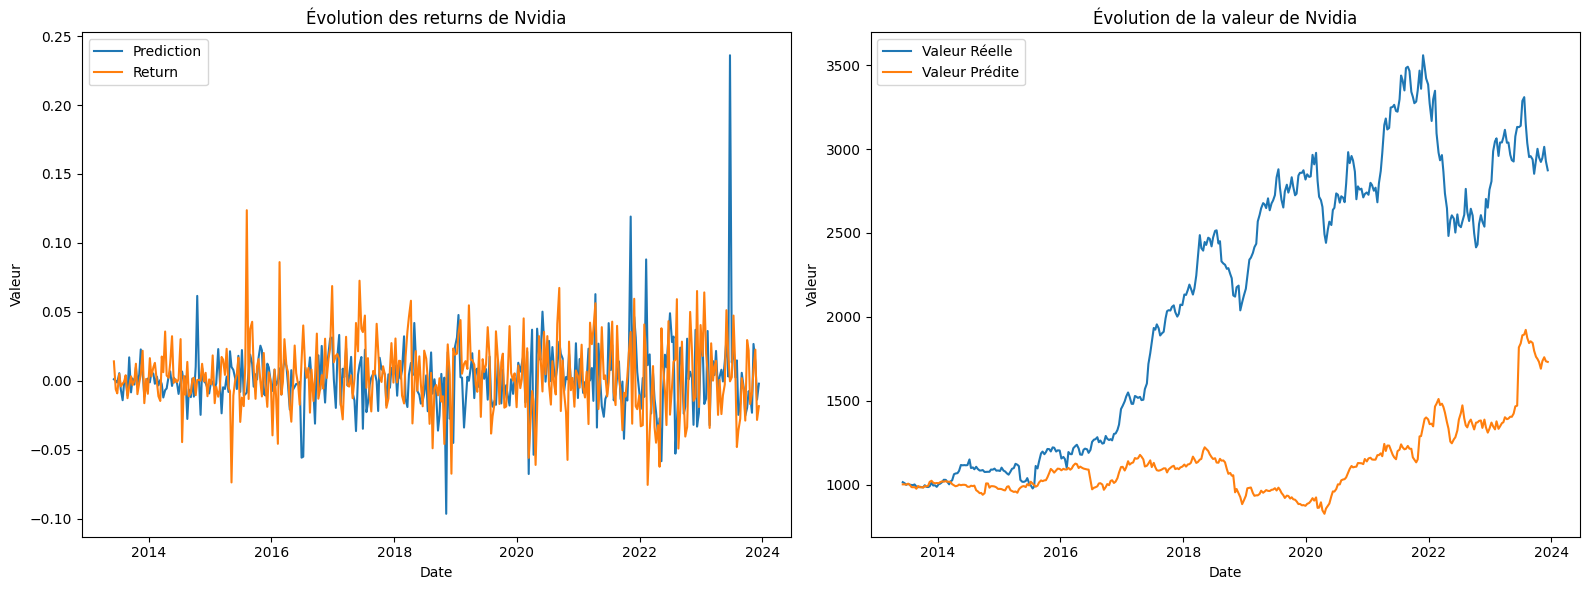

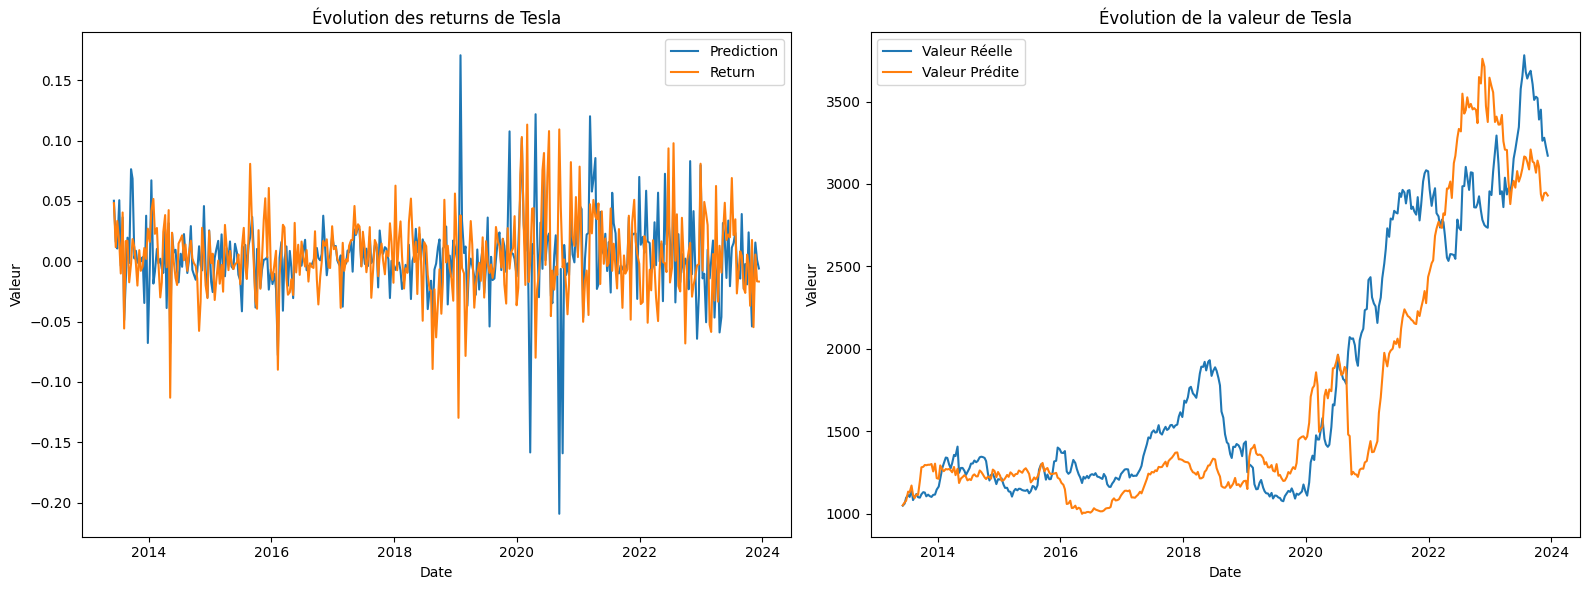

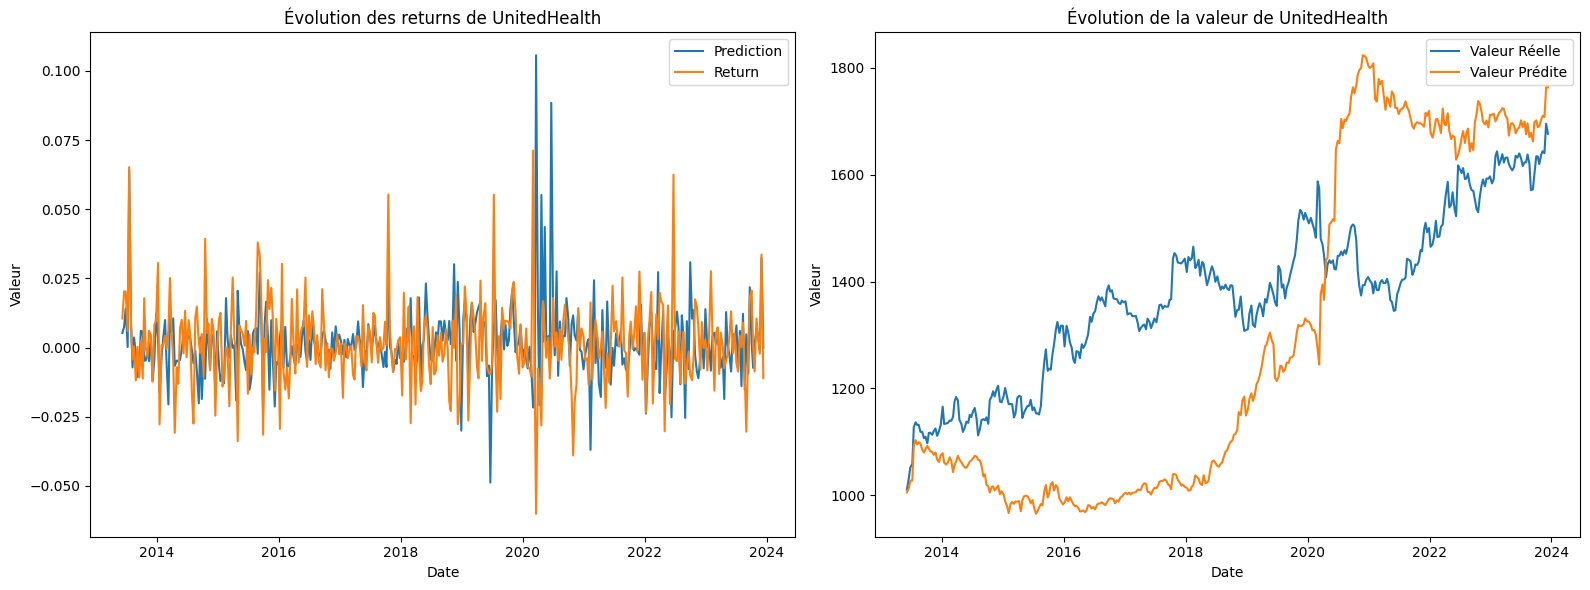

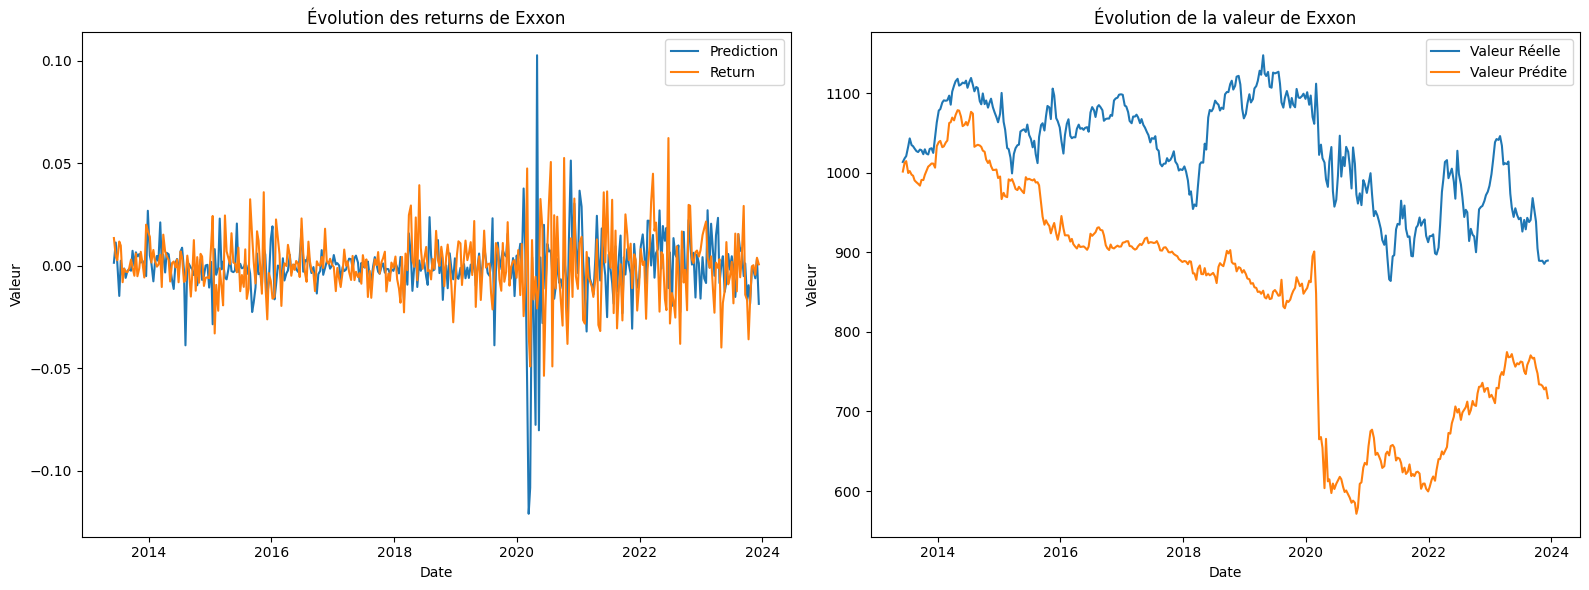

In [58]:
for key in predictions_dic:
    # Création d'une figure et de deux sous-graphiques
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Appel des fonctions pour remplir chaque sous-graphique
    display_return(predictions_dic[key], key, ax1)
    display_evolution(predictions_dic[key], key, ax2)

    # Ajustement de la disposition et affichage de la figure
    plt.tight_layout()
    plt.show()

# Calcul du portefeuille

In [20]:
dfs_to_concat = []

for name, df in predictions_dic.items():
    df['Date'] = pd.to_datetime(df['Date'])

    dfs_to_concat.append(df[['Date', 'Prediction', 'Return']])

portfolio_predictions = pd.concat(dfs_to_concat)

portfolio_avg_predictions = portfolio_predictions.groupby('Date').mean().reset_index()

print(portfolio_avg_predictions.head())

        Date  Prediction    Return
0 2013-06-04    0.009461 -0.004242
1 2013-06-13    0.002831  0.008814
2 2013-06-24    0.005934 -0.007535
3 2013-07-03    0.006677  0.000442
4 2013-07-15   -0.008052  0.000032


In [27]:
fig = go.Figure()

# Ajout de la série financière
fig.add_trace(go.Scatter(x = portfolio_avg_predictions.Date, 
                         y = portfolio_avg_predictions['Prediction'],
                         mode = 'lines',
                         name ='Return', 
                         fill = "tozeroy"))

fig.add_trace(go.Scatter(x = portfolio_avg_predictions.Date, 
                         y = portfolio_avg_predictions['Return'],
                         mode = 'lines',
                         name ='Return', 
                         fill = "tozeroy"))

# Mise à jour des titres
fig.update_layout(title="Évolution des returns du ptf",
                  xaxis_title='Date',
                  yaxis_title='Valeur')

# Affichage du graphique
fig.show()

In [24]:
portfolio_avg_predictions['Real_Portfolio_Value'] = 1000 * (1 + portfolio_avg_predictions['Return']).cumprod()
portfolio_avg_predictions['Predicted_Portfolio_Value'] = 1000 * (1 + portfolio_avg_predictions['Prediction']).cumprod()

In [25]:
portfolio_avg_predictions

,Date,Prediction,Return,Real_Portfolio_Value,Predicted_Portfolio_Value
0,2013-06-04,0.009461,-0.004242,995.757833,1009.460571
1,2013-06-13,0.002831,0.008814,1004.533975,1012.318848
2,2013-06-24,0.005934,-0.007535,996.964481,1018.326172
3,2013-07-03,0.006677,0.000442,997.405389,1025.125854
4,2013-07-15,-0.008052,0.000032,997.437734,1016.871948
...,...,...,...,...,...
375,2023-11-06,0.001296,0.003132,1839.182453,1719.151367
376,2023-11-15,0.002415,-0.001536,1836.357423,1723.303711
377,2023-11-27,0.000738,-0.000626,1835.208730,1724.576294
378,2023-12-06,-0.000437,-0.008377,1819.835447,1723.822632


In [26]:
fig = go.Figure()

# Ajout de la série financière
fig.add_trace(go.Scatter(x = portfolio_avg_predictions.Date, 
                         y = portfolio_avg_predictions['Real_Portfolio_Value'],
                         mode = 'lines',
                         name ='réel', 
                         fill = "tozeroy"))

fig.add_trace(go.Scatter(x = portfolio_avg_predictions.Date, 
                         y = portfolio_avg_predictions['Predicted_Portfolio_Value'],
                         mode = 'lines',
                         name ='prédit', 
                         fill = "tozeroy"))

# Mise à jour des titres
fig.update_layout(title="Évolution de la valeur de ptf",
                  xaxis_title='Date',
                  yaxis_title='Valeur')

# Affichage du graphique
fig.show()